In [1]:
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
pd.set_option("display.max_rows", None)  # 모든 행 출력
pd.set_option("display.max_columns", None)  # 모든 열 출력
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import os
from itertools import product
from functions import (load_parameters, load_generation_data, load_price_data, generate_randomized_generation,
generate_rt_scenarios, plot_generation_data, plot_randomized_generation, plot_scenarios_for_generator, plot_rt_scenarios, plot_summary)

generation_data, I, T = load_generation_data(date_filter="2022-07-18")
S, R, P_RT, K, K0, M1, M2 = load_parameters(I, T, generation_data)
P_DA, P_PN = load_price_data()

✅ 총 4개 파일을 불러왔습니다: 1201.csv, 137.csv, 397.csv, 514.csv
📊 데이터 Shape: I=4, T=24, S=20
✅ 시뮬레이션 초기화 완료: S=20, Randomness='high', M1=486.00, M2=924.00


### Optimization w/o i*

In [9]:
target_i = 2  # RDC를 도출할 대상 DER

In [10]:
# === 설정 ===
I_set = [i for i in range(I) if i != target_i]
M1 = np.maximum(R[I_set], K[I_set, None, None]).max()
M2 = max(R[I_set].sum(axis=0).max(), K[I_set].sum())

model = gp.Model(f"set_without_{target_i}")
model.setParam("MIPGap", 1e-7)

# 변수 정의
x = model.addVars(I_set, T, vtype=GRB.CONTINUOUS, lb=0, name="x")
ep = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, name="e_plus")
em = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, name="e_minus")
yp = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
ym = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
z = model.addVars(I_set, T + 1, S, vtype=GRB.CONTINUOUS, name="z")
zc = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, name="z_charge")
zd = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, name="z_discharge")
d = model.addVars(I_set, I_set, T, S, vtype=GRB.CONTINUOUS, lb=0, name="d")

p1 = model.addVars(I_set, T, S, vtype=GRB.BINARY, name="p1")
p2 = model.addVars(I_set, T, S, vtype=GRB.BINARY, name="p2")
p3 = model.addVars(I_set, T, S, vtype=GRB.BINARY, name="p3")
p4 = model.addVars(I_set, T, S, vtype=GRB.BINARY, name="p4")

model.update()

# 목적함수
obj = gp.quicksum(P_DA[t] * x[i, t] for i in I_set for t in range(T)) + gp.quicksum(
    (1 / S) * (
        P_RT[t, s] * gp.quicksum(ep[i, t, s] for i in I_set) -
        P_PN[t] * gp.quicksum(em[i, t, s] for i in I_set)
    )
    for t in range(T) for s in range(S)
)
model.setObjective(obj, GRB.MAXIMIZE)

# 제약조건
for i, t, s in product(I_set, range(T), range(S)):
    model.addConstr(R[i, t, s] - x[i, t] == yp[i, t, s] - ym[i, t, s] + zc[i, t, s] - zd[i, t, s])
    model.addConstr(yp[i, t, s] <= R[i, t, s])
    model.addConstr(zd[i, t, s] <= z[i, t, s])
    model.addConstr(zc[i, t, s] <= K[i] - z[i, t, s])
    model.addConstr(yp[i, t, s] <= M1 * p3[i, t, s])
    model.addConstr(ym[i, t, s] <= M1 * (1 - p3[i, t, s]))
    model.addConstr(ym[i, t, s] <= M1 * p2[i, t, s])
    model.addConstr(zc[i, t, s] <= M1 * (1 - p2[i, t, s]))
    model.addConstr(zc[i, t, s] <= M1 * p1[i, t, s])
    model.addConstr(zd[i, t, s] <= M1 * (1 - p1[i, t, s]))
    model.addConstr(z[i, t, s] <= K[i])
    model.addConstr(z[i, t + 1, s] == z[i, t, s] + zc[i, t, s] - zd[i, t, s])

for i, s in product(I_set, range(S)):
    model.addConstr(z[i, 0, s] == K0[i])

for i, t, s in product(I_set, range(T), range(S)):
    model.addConstr(ep[i, t, s] == yp[i, t, s] - gp.quicksum(d[i, j, t, s] for j in I_set if j != i))
    model.addConstr(em[i, t, s] == ym[i, t, s] - gp.quicksum(d[j, i, t, s] for j in I_set if j != i))
    model.addConstr(gp.quicksum(ep[i, t, s] for i in I_set) <= M2 * p4[i, t, s])
    model.addConstr(gp.quicksum(em[i, t, s] for i in I_set) <= M2 * (1 - p4[i, t, s]))
    model.addConstr(d[i, i, t, s] == 0)

# 최적화
model.optimize()

x_vals = np.array([[x[i, t].X for t in range(T)] for i in I_set])
yp_vals = np.array([[[yp[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
ym_vals = np.array([[[ym[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
z_vals  = np.array([[[z[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
zc_vals = np.array([[[zc[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
zd_vals = np.array([[[zd[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
ep_vals = np.array([[[ep[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
em_vals = np.array([[[em[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
d_vals = np.array([[[[d[i, j, t, s].X for s in range(S)] for t in range(T)] for j in I_set] for i in I_set])

Set parameter MIPGap to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  1e-07

Optimize a model with 24540 rows, 20292 columns and 63420 nonzeros
Model fingerprint: 0x2c038cab
Variable types: 14532 continuous, 5760 integer (5760 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  Objective range  [2e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+02]
Presolve removed 14147 rows and 10278 columns
Presolve time: 0.08s
Presolved: 10393 rows, 10014 columns, 31890 nonzeros
Variable types: 6970 continuous, 3044 integer (3044 binary)
Found heuristic solution: objective 374923.55962
Found heuristic solution: objective 384789.55192

Root relaxation: objective 6.650240e+05, 9318 iterations, 0.15 seconds (0.18 work units)

    Nodes    |    Current Node    |     Objective Bounds

### Supply-Demand Curve

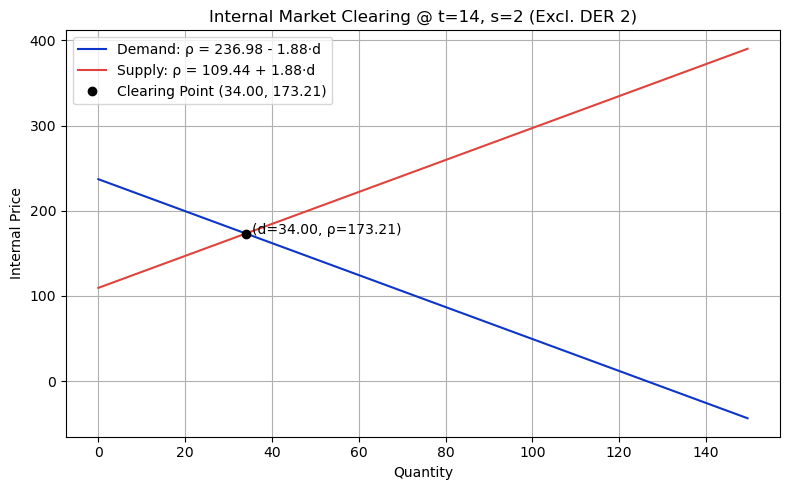

In [19]:
i_map = {i: idx for idx, i in enumerate(I_set)}
t, s = 14, 2

# === Step 1: 공급 총량 및 수익 계산 ===
total_supply = sum(yp_vals[i_map[i], t, s] for i in I_set)
total_demand = sum(ym_vals[i_map[i], t, s] for i in I_set)

given_profit, received_profit, realized_supply, realized_demand = 0, 0, 0, 0
for i in I_set:
    for j in I_set:
        if i == j:
            continue
        given_profit += d_vals[i_map[i], i_map[j], t, s] * P_PN[t]
        received_profit += d_vals[i_map[j], i_map[i], t, s] * P_RT[t, s]
        realized_supply += d_vals[i_map[i], i_map[j], t, s]
        realized_demand += d_vals[i_map[j], i_map[i], t, s]

# 수요곡선: ρ(d) = a_d - b_d * d
a_d = P_PN[t]
b_d = 2 * (a_d * realized_demand - received_profit) / (realized_demand ** 2)

# 공급곡선: ρ(d) = a_s + b_s * d
a_s = P_RT[t, s]
b_s = 2 * (given_profit - a_s * realized_supply) / (realized_supply ** 2)

# === 교차점 계산 ===
q_clearing = (a_d - a_s) / (b_d + b_s) if (b_d + b_s) != 0 else 0
p_clearing = a_s + b_s * q_clearing

# === 시각화 ===
x_max = 1.1 * max(total_demand, total_supply, q_clearing)
quantities = np.linspace(0, x_max, 300)
demand_prices = a_d - b_d * quantities
supply_prices = a_s + b_s * quantities

plt.figure(figsize=(8, 5))
plt.plot(quantities, demand_prices, label=f"Demand: ρ = {a_d:.2f} - {b_d:.2f}·d", color='#0D35C9')
plt.plot(quantities, supply_prices, label=f"Supply: ρ = {a_s:.2f} + {b_s:.2f}·d", color='#E0433C')
plt.plot(q_clearing, p_clearing, 'ko', label=f"Clearing Point ({q_clearing:.2f}, {p_clearing:.2f})")
plt.annotate(f"(d={q_clearing:.2f}, ρ={p_clearing:.2f})", 
             xy=(q_clearing, p_clearing), 
             xytext=(q_clearing + 1.5, p_clearing - 1))

plt.title(f"Internal Market Clearing @ t={t}, s={s} (Excl. DER {target_i})")
plt.xlabel("Quantity")
plt.ylabel("Internal Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Residual Demand Curve

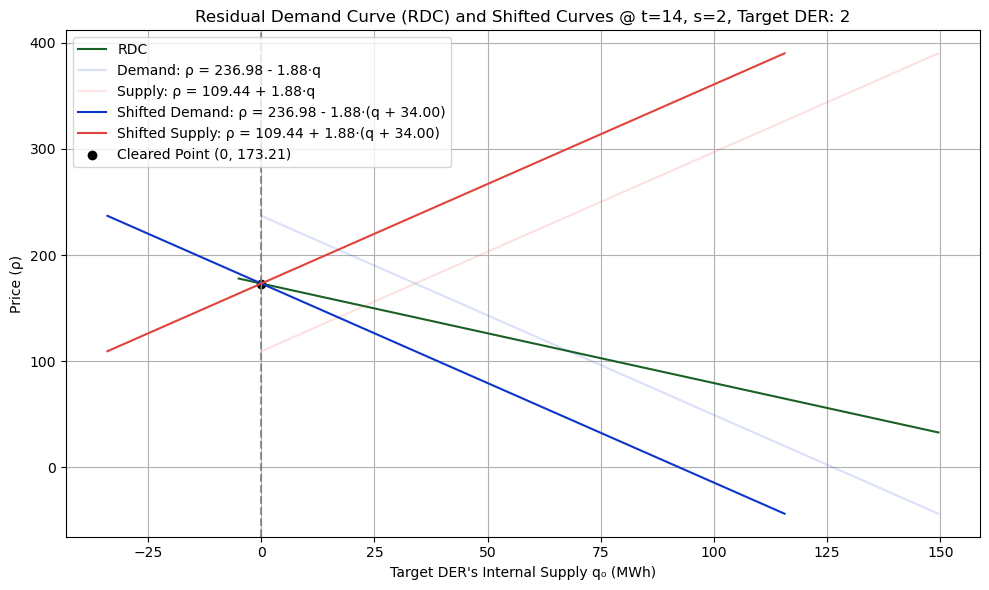

In [20]:
# === 수요 및 공급 함수 정의 ===
rho_d = lambda q: a_d - b_d * q  # 수요곡선: ρ_d(q) = a_d - b_d·q
rho_s = lambda q: a_s + b_s * q  # 공급곡선: ρ_s(q) = a_s + b_s·q

# === Step 1: Cleared Point 계산 ===
denominator = b_d + b_s
q_star = (a_d - a_s) / denominator if denominator != 0 else 0
p_star = rho_d(q_star)

# === Step 2: RDC 계산 (타겟 DER이 공급 q₀만큼 제공할 때 가격 변화)
q0_list = np.linspace(-5, 1.1 * total_supply, 100)
clearing_quantities = []
clearing_prices = []

for q0 in q0_list:
    # 공급곡선이 오른쪽으로 q₀만큼 평행이동
    q_cleared = (a_d - a_s + b_s * q0) / (b_d + b_s) if (b_d + b_s) != 0 else 0
    p_cleared = rho_d(q_cleared)
    clearing_quantities.append(q0)
    clearing_prices.append(p_cleared)

# === Step 3: 수요/공급곡선 (Cleared Point를 원점으로 평행이동)
x_shifted = np.linspace(-q_star, 1.1 * total_supply - q_star, 300)
demand_shifted = rho_d(x_shifted + q_star)
supply_shifted = rho_s(x_shifted + q_star)

# === Step 4: 시각화
plt.figure(figsize=(10, 6))

# (1) 원래 수요/공급곡선 + RDC
plt.plot(q0_list, clearing_prices, label="RDC", color='#196124')
plt.plot(quantities, rho_d(quantities), label=f"Demand: ρ = {a_d:.2f} - {b_d:.2f}·q", color='#0D35C9', alpha=0.15)
plt.plot(quantities, rho_s(quantities), label=f"Supply: ρ = {a_s:.2f} + {b_s:.2f}·q", color='#E0433C', alpha=0.15)

# (2) Shifted 기준 수요/공급곡선 (q* → 0)
plt.plot(x_shifted, demand_shifted, label=f"Shifted Demand: ρ = {a_d:.2f} - {b_d:.2f}·(q + {q_star:.2f})", linestyle='-', color='#0D35C9')
plt.plot(x_shifted, supply_shifted, label=f"Shifted Supply: ρ = {a_s:.2f} + {b_s:.2f}·(q + {q_star:.2f})", linestyle='-', color='#E0433C')
plt.axvline(0, color="#6C6E6C", linestyle="--", alpha=0.7)
plt.scatter(0, p_star, color="black", label=f"Cleared Point (0, {p_star:.2f})")


# === 그래프 설정
plt.title(f"Residual Demand Curve (RDC) and Shifted Curves @ t={t}, s={s}, Target DER: {target_i}")
plt.xlabel("Target DER's Internal Supply q₀ (MWh)")
plt.ylabel("Price (ρ)")
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

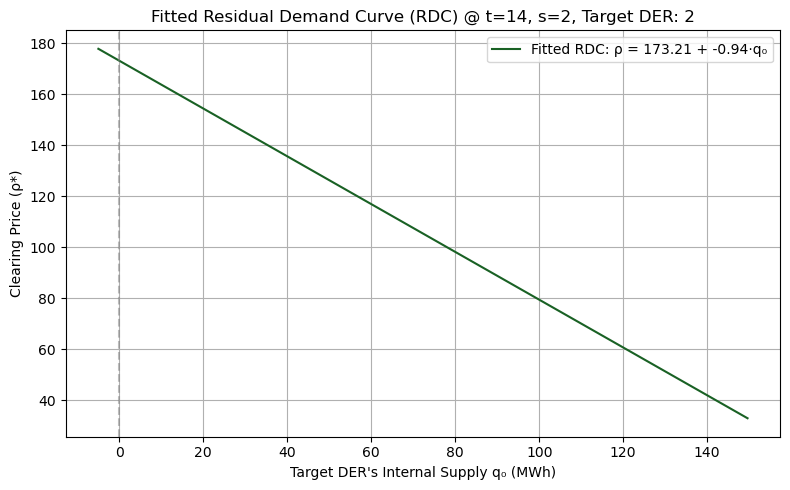

In [21]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# 다항 회귀를 통한 RDC 근사 ===
q0_array = np.array(clearing_quantities).reshape(-1, 1)
price_array = np.array(clearing_prices)

# 다항차수 설정
poly = PolynomialFeatures(degree=1)
X_poly = poly.fit_transform(q0_array)

model = LinearRegression()
model.fit(X_poly, price_array)

# 회귀 계수 추출1 -> af
intercept = model.intercept_
coeffs = model.coef_ 

# 근사된 RDC 함수 정의
def rdc_poly(q0):
    return intercept + coeffs[1] * q0

# 시각화용 평활 q₀
q0_smooth = np.linspace(min(q0_list), max(q0_list), 300)
rdc_fitted = rdc_poly(q0_smooth)

# === Step 6: 근사된 RDC 시각화 ===
plt.figure(figsize=(8, 5))
plt.plot(q0_smooth, rdc_fitted, label=f"Fitted RDC: ρ = {intercept:.2f} + {coeffs[1]:.2f}·q₀", color='#196124')
plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
plt.title(f"Fitted Residual Demand Curve (RDC) @ t={t}, s={s}, Target DER: {target_i}")
plt.xlabel("Target DER's Internal Supply q₀ (MWh)")
plt.ylabel("Clearing Price (ρ*)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### RDC for all t, s